In [432]:
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt

In [408]:
df = pd.read_csv('county_storage.csv')
print(df.head(30))
print(len(df))

          Date case_rate cases death_rate deaths               location
0   04/15/2020    100.56    21        NaN    NaN   CITY OF AGOURA HILLS
1   04/15/2020     42.66    37        NaN    NaN       CITY OF ALHAMBRA
2   04/15/2020     43.29    25        NaN    NaN        CITY OF ARCADIA
3   04/15/2020     29.77     5        NaN    NaN        CITY OF ARTESIA
4   04/15/2020         0     0        NaN    NaN         CITY OF AVALON
5   04/15/2020     43.96    22        NaN    NaN          CITY OF AZUSA
6   04/15/2020     44.29    34        NaN    NaN   CITY OF BALDWIN PARK
7   04/15/2020    176.15    64        NaN    NaN           CITY OF BELL
8   04/15/2020     90.55    39        NaN    NaN   CITY OF BELL GARDENS
9   04/15/2020     70.75    55        NaN    NaN     CITY OF BELLFLOWER
10  04/15/2020    225.96    78        NaN    NaN  CITY OF BEVERLY HILLS
11  04/15/2020        --    --        NaN    NaN       CITY OF BRADBURY
12  04/15/2020     104.5   112        NaN    NaN        CITY OF 

In [409]:
# Let's look at each columns closer to find if there are any more null values.
null_each_col={}

for col in df.columns:
    null_count=df[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)

# There are no null values in 'Date', 'case_rate', ' cases', and 'location' column. 
# There are 9512 null values in 'death_rate' and 'deaths' column
# Those null values could mean either 0 deaths or unknown amount of death count.

{'Date': 0, 'case_rate': 0, 'cases': 0, 'death_rate': 9512, 'deaths': 9512, 'location': 0}


In [410]:
# Date/Time Cleaning

date_format="%m/%d/%Y"

new_date_format=[]
for date in df['Date']:
    date_new=dt.datetime.strptime(date,date_format)
    new_date_format.append(date_new)

df['Date']=new_date_format
print(df.head())

        Date case_rate cases death_rate deaths              location
0 2020-04-15    100.56    21        NaN    NaN  CITY OF AGOURA HILLS
1 2020-04-15     42.66    37        NaN    NaN      CITY OF ALHAMBRA
2 2020-04-15     43.29    25        NaN    NaN       CITY OF ARCADIA
3 2020-04-15     29.77     5        NaN    NaN       CITY OF ARTESIA
4 2020-04-15         0     0        NaN    NaN        CITY OF AVALON


In [411]:
# Cleaning location names

string1='CITY OF '
string2='LOS ANGELES - '
string3='UNINCORPORATED - '
location=df['location']
df['location']=df['location'].str.replace(string1,'')
df['location']=df['location'].str.replace(string2,'')
df['location']=df['location'].str.replace(string3,'')
print(df.head())


        Date case_rate cases death_rate deaths      location
0 2020-04-15    100.56    21        NaN    NaN  AGOURA HILLS
1 2020-04-15     42.66    37        NaN    NaN      ALHAMBRA
2 2020-04-15     43.29    25        NaN    NaN       ARCADIA
3 2020-04-15     29.77     5        NaN    NaN       ARTESIA
4 2020-04-15         0     0        NaN    NaN        AVALON


In [412]:
len(df)

30327

In [413]:
df=df.replace('--',np.nan)

# Let's look at each columns closer to find if there are any more null values.
null_each_col={}

for col in df.columns:
    null_count=df[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)

{'Date': 0, 'case_rate': 472, 'cases': 472, 'death_rate': 9512, 'deaths': 9512, 'location': 0}


In [414]:
# Converting object columns to float data type
print(len(df))
df=df[df['cases'].str.isnumeric()==True]
df[['cases','case_rate','death_rate','deaths']]=df[['cases','case_rate','death_rate','deaths']].astype(float)
df.info()


30327
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29791 entries, 0 to 30326
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        29791 non-null  datetime64[ns]
 1   case_rate   29791 non-null  float64       
 2   cases       29791 non-null  float64       
 3   death_rate  20754 non-null  float64       
 4   deaths      20754 non-null  float64       
 5   location    29791 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.6+ MB


In [415]:
print(len(df))
df_cases=df.dropna(axis=0,subset=['case_rate','cases'])
print(len(df_cases))

29791
29791


In [416]:

for col in df_cases.columns:
    null_count=df_cases[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)

{'Date': 0, 'case_rate': 0, 'cases': 0, 'death_rate': 9037, 'deaths': 9037, 'location': 0}


In [417]:
df['Date']
df[df['Date']=='2020-04-15']['cases'][:10]


0    21.0
1    37.0
2    25.0
3     5.0
4     0.0
5    22.0
6    34.0
7    64.0
8    39.0
9    55.0
Name: cases, dtype: float64

In [440]:
df_case_sum={}
dates=[]
case_sums=[]
for date in df['Date'].unique():
    dates.append(date)
    case_sum=df[df['Date']==date]['cases'].sum()
    df_case_sum[date]=case_sum
    case_sums.append(case_sum)

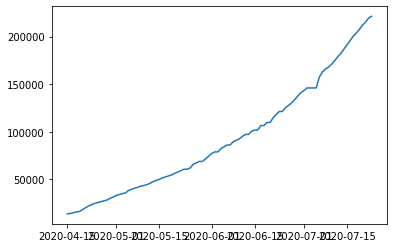

In [441]:
plt.plot(dates,case_sums)